# Waring!

I still haven't figured out the best parameter combinations for large dimensional runs.  Current parameters hang on my 2016 MBP.

In [1]:
from common import Problem
import matplotlib.pyplot as plt
import numpy as nap
import approxposterior as approx
import corner

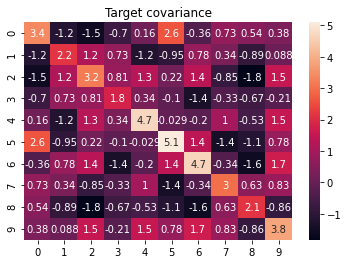

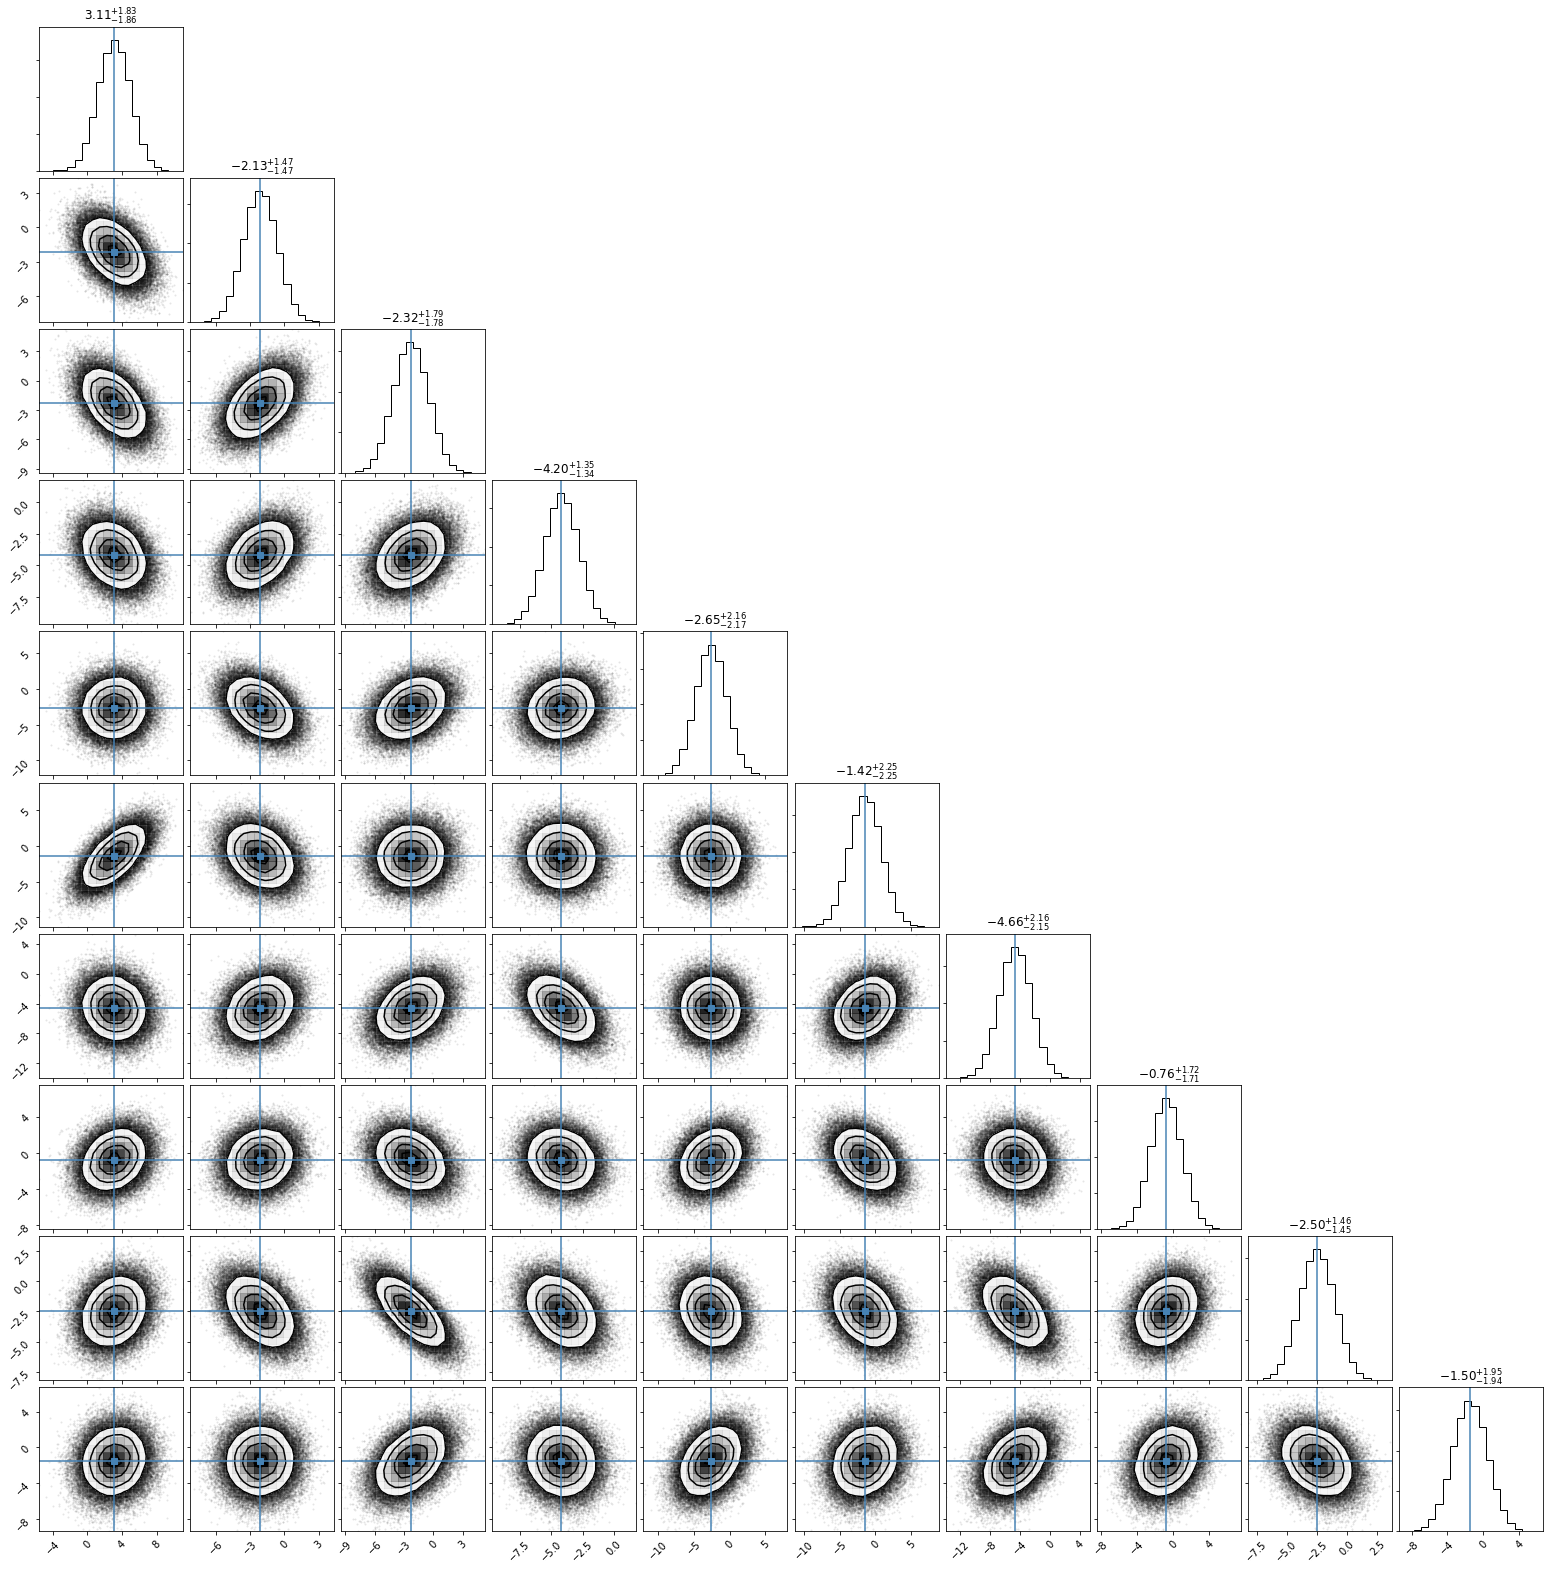

In [2]:
problem = Problem(10)
problem.plot_cov()
problem.plot_rvs();

In [3]:
m0 = 1000                        # Initial size of training set
m = 100                          # Number of new points to find each iteration
nmax = 3                         # Maximum number of iterations
bounds = np.array([(-10,10)]*problem.ndim)  # Prior bounds
algorithm = "bape"                # Use the Kandasamy et al. (2017) formalism


# emcee MCMC parameters
nwalkers = 1000
samplerKwargs = {"nwalkers" : nwalkers}      # emcee.EnsembleSampler parameters
mcmcKwargs = {"iterations" : 10} # emcee.EnsembleSampler.run_mcmc parameters

In [4]:
# Sample design points from prior
def priorSample(n):
    return np.random.rand(n, problem.ndim)*np.diff(bounds, axis=1).squeeze() + bounds[:, 0]

def lnprior(theta):
    if ((-10 > theta) | (theta > 10)).any():
        return -np.inf
    return 1.0

np.random.seed(5783729)
problem.reset_ncall()

theta = priorSample(m0)
y = np.fromiter((problem.lnL(t) for t in theta), float)

# Default GP with an ExpSquaredKernel
gp = approx.gpUtils.defaultGP(theta, y, white_noise=-12)

In [ ]:
# Initialize object using the Wang & Li (2018) Rosenbrock function example
ap = approx.ApproxPosterior(theta=theta,
                            y=y,
                            gp=gp,
                            lnprior=lnprior,
                            lnlike=problem.lnL,
                            priorSample=priorSample,
                            bounds=bounds,
                            algorithm=algorithm)

# Run!
ap.run(m=m, nmax=nmax, estBurnin=True, nGPRestarts=10, optGPEveryN=m, mcmcKwargs=mcmcKwargs,
       cache=False, samplerKwargs=samplerKwargs, verbose=True, thinChains=False,
       onlyLastMCMC=True)

In [ ]:
# Check out the final posterior distribution!

# Load in chain from last iteration
samples = ap.sampler.get_chain(discard=ap.iburns[-1], flat=True, thin=ap.ithins[-1])

# Corner plot!
fig = corner.corner(samples, quantiles=[0.16, 0.5, 0.84], show_titles=True,
                    scale_hist=True, plot_contours=True)

# Plot where forward model was evaluated
fig.axes[2].scatter(ap.theta[m0:,0], ap.theta[m0:,1], s=10, color="red", zorder=20);

In [ ]:
print(problem.ncall)